# ResNet-18 attacks

## Librerías

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary

from torchvision import models
import torchvision.transforms as transforms

import torchattacks

from utils.datasets import MyDataset
from utils.evaluation import NormalizationLayer, get_topk_accuracy
from utils.evaluation import plot_adversarial, get_same_predictions, get_different_predictions

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Modelo

De acuerdo a la documentación de PyTorch se tiene lo siguiente:

- [ResNet](https://pytorch.org/hub/pytorch_vision_resnet/): top-1-error de 30.24% and top-5-error de 10.92%.  La salida tiene puntuaciones no normalizadas, para obtener probabilidades hay que ejecutar un softmax en la salida.

Por la forma en que funciona [Adversarial-Attacks-PyTorch](https://github.com/Harry24k/adversarial-attacks-pytorch) las imágenes de entrada que se le tienen que pasar deben estar en el rango [0,1], pero los modelos pre-entrenados de PyTorch esperan imágenes normalizadas, las cuáles no están en el [0,1]. La forma de resolver ésto es añadiendo una capa de normalización al inicio. Ver [Demo - White Box Attack (Imagenet)](https://nbviewer.jupyter.org/github/Harry24k/adversarial-attacks-pytorch/blob/master/demos/White%20Box%20Attack%20%28ImageNet%29.ipynb) para un ejemplo con los modelos entrenados en ImageNet.

In [4]:
resnet18 = nn.Sequential(
    NormalizationLayer(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    models.resnet18(pretrained=True))

In [5]:
summary(resnet18)

Layer (type:depth-idx)                        Param #
Sequential                                    --
├─NormalizationLayer: 1-1                     --
├─ResNet: 1-2                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock:

In [6]:
# Lo movemos a la GPU, en caso de que haya
resnet18 = resnet18.to(device)

## Dataset & dataloader

In [7]:
my_dataset = MyDataset(root_dir='../../data/images/', 
                       images_csv='../../data/images.csv',
                       categories_csv='../../data/categories.csv',
                       normalize=False)

In [8]:
dataloader  = torch.utils.data.DataLoader(my_dataset, batch_size=32, shuffle=False, num_workers=4)

## Ataques

Los siguientes son todos los ataques que están disponibles en [Adversarial-Attacks-PyTorch](https://github.com/Harry24k/adversarial-attacks-pytorch):

```python
attacks = [torchattacks.FGSM(model, eps=8/255),
           torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=7),
           torchattacks.CW(model, c=1, kappa=0, steps=1000, lr=0.01),
           torchattacks.RFGSM(model, eps=8/255, alpha=4/255, steps=1),
           torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=7),
           torchattacks.FFGSM(model, eps=8/255, alpha=12/255),
           torchattacks.TPGD(model, eps=8/255, alpha=2/255, steps=7),
           torchattacks.MIFGSM(model, eps=8/255, decay=1.0, steps=5),
           torchattacks.APGD(model, eps=8/255, steps=10),
           torchattacks.FAB(model, eps=8/255),
           torchattacks.Square(model, eps=8/255),
           torchattacks.PGDDLR(model, eps=8/255, alpha=2/255, steps=7),
           torchattacks.DeepFool(model, steps=50, overshoot=0.02),
           torchattacks.OnePixel(model, pixels=1, steps=75, popsize=400),
           torchattacks.SparseFool(model, steps=20, lam=3, overshoot=0.02)]
```

No probaré todos ya que son bastantes, por lo que tomaré:

- `torchattacks.FGSM`: fue el primer algortimo para generar ataques, ver [Explaining and harnessing adversarial examples (Goodfellow et al., 2014)](https://arxiv.org/abs/1412.6572).
- `torchattacks.PGD`: uno de los algoritmos que usa el gradiente, he visto que lo usan en varios lugares, ver [Towards Deep Learning Models Resistant to Adversarial Attacks (Mardry et al., 2017)](https://arxiv.org/abs/1706.06083).
- `torchattacks.MIFGSM`: también usa el gradiente pero le añade momento, ver [Boosting Adversarial Attacks with Momentum (Dong et al., 2017)](https://arxiv.org/abs/1710.06081). Este algoritmo fue uno de los ganadores de la competencia [NIPS 2017: Non-targeted Adversarial Attack
](https://www.kaggle.com/c/nips-2017-non-targeted-adversarial-attack/overview).
- `torchattacks.OnePixel`: ataque a un sólo pixel, quiero jugar con este algoritmo sólo para ver qué tan robustas son las redes que usaré y está divertido, ver [One pixel attack for fooling deep neural networks (Su et al., 2019)](https://arxiv.org/abs/1710.08864).

Usaré algunos de los parámetros que recomienda para un ataque de caja blanca con ImageNet, ver [White Box Attack (Imagenet)](https://nbviewer.jupyter.org/github/Harry24k/adversarial-attacks-pytorch/blob/master/demos/White%20Box%20Attack%20%28ImageNet%29.ipynb).

### FGSM

In [9]:
%%time

attack = torchattacks.FGSM(resnet18, eps=1/255)
attack.set_return_type('float') 
attack.save(dataloader, save_path='models/resnet18/FGSM.pt', verbose=True)

- Save Progress: 100.00 % / Accuracy: 3.50 % / L2: 1.51492
- Save Complete!
CPU times: user 5.61 s, sys: 932 ms, total: 6.54 s
Wall time: 8.7 s


### PGD

In [10]:
%%time

attack = torchattacks.PGD(resnet18, eps=1/255, alpha=1/255, steps=3)
attack.set_return_type('float') 
attack.save(dataloader, save_path='models/resnet18/PGD.pt', verbose=True)

- Save Progress: 100.00 % / Accuracy: 0.80 % / L2: 1.39460
- Save Complete!
CPU times: user 10.8 s, sys: 1.74 s, total: 12.6 s
Wall time: 13.9 s


### MIFGSM

In [11]:
%%time

attack = torchattacks.MIFGSM(resnet18, eps=1/255, decay=1.0, steps=3)
attack.set_return_type('float') 
attack.save(dataloader, save_path='models/resnet18/MIFGSM.pt', verbose=True)

- Save Progress: 100.00 % / Accuracy: 1.00 % / L2: 1.32706
- Save Complete!
CPU times: user 11 s, sys: 1.91 s, total: 12.9 s
Wall time: 14.3 s


### OnePixel

In [12]:
%%time

attack = torchattacks.OnePixel(resnet18, pixels=1, steps=5, popsize=20)
attack.set_return_type('float') 
attack.save(dataloader, save_path='models/resnet18/OnePixel.pt', verbose=True)

- Save Progress: 100.00 % / Accuracy: 78.70 % / L2: 0.85650
- Save Complete!
CPU times: user 1min 43s, sys: 1.64 s, total: 1min 45s
Wall time: 1min 47s


## Evaluación

### Limpio

En [torchvision.models](https://pytorch.org/vision/stable/models.html) vemos que el accuracy es parecido a lo que sale con este dataset.

In [13]:
dataloader_eval  = torch.utils.data.DataLoader(my_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true, y_pred, accuracy_1, accuracy_5 = get_topk_accuracy(resnet18, dataloader_eval)
print(f'Accuracy@1: {accuracy_1}')
print(f'Accuracy@5: {accuracy_5}')

100%|██████████| 1000/1000 [00:04<00:00, 213.12it/s]

Accuracy@1: 82.5
Accuracy@5: 95.39999999999999


### FGSM

In [14]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/resnet18/FGSM.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(resnet18, adv_loader)
print(f'Accuracy@1: {accuracy_1}')
print(f'Accuracy@5: {accuracy_5}')

100%|██████████| 1000/1000 [00:04<00:00, 207.32it/s]

Accuracy@1: 3.5000000000000004
Accuracy@5: 24.3


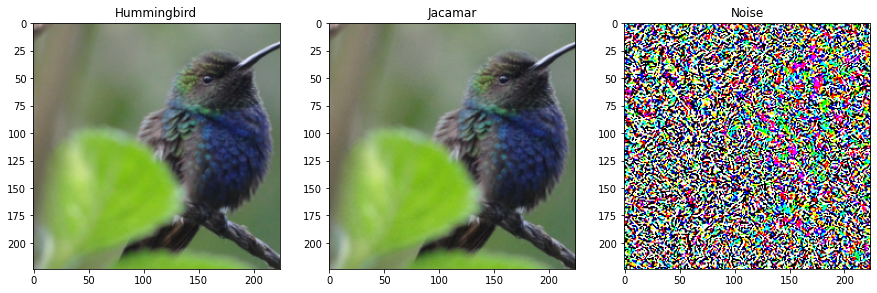

In [15]:
# {650: 'bee', 231: 'zebra', 834: 'white shark', 891: 'hummingbird', 535: 'panda'}
i = 891
plot_adversarial(my_dataset, adv_dataset, y_pred, y_pred_adv, i)

### PGD

In [16]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/resnet18/PGD.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(resnet18, adv_loader)
print(f'Accuracy@1: {accuracy_1}')
print(f'Accuracy@5: {accuracy_5}')

100%|██████████| 1000/1000 [00:05<00:00, 198.79it/s]

Accuracy@1: 0.8
Accuracy@5: 14.6


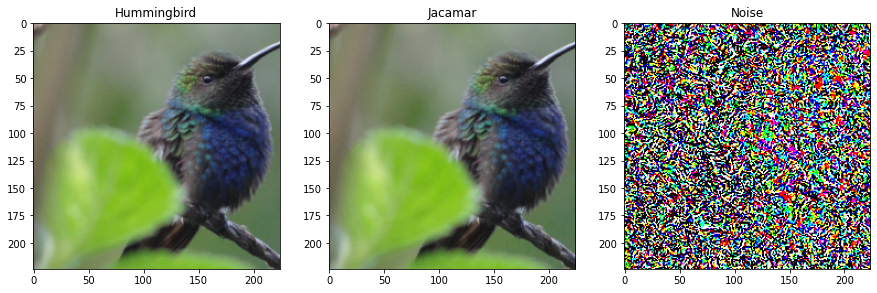

In [17]:
# {650: 'bee', 231: 'zebra', 834: 'white shark', 891: 'hummingbird', 535: 'panda'}
i = 891
plot_adversarial(my_dataset, adv_dataset, y_pred, y_pred_adv, i)

### MIFGSM

In [18]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/resnet18/MIFGSM.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(resnet18, adv_loader)
print(f'Accuracy@1: {accuracy_1}')
print(f'Accuracy@5: {accuracy_5}')

100%|██████████| 1000/1000 [00:04<00:00, 208.27it/s]

Accuracy@1: 1.0
Accuracy@5: 13.5


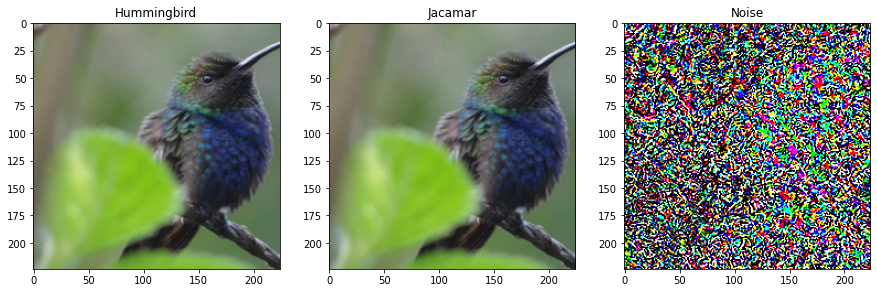

In [19]:
# {650: 'bee', 231: 'zebra', 834: 'white shark', 891: 'hummingbird', 535: 'panda'}
i = 891
plot_adversarial(my_dataset, adv_dataset, y_pred, y_pred_adv, i)

### OnePixel

In [20]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/resnet18/OnePixel.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(resnet18, adv_loader)
print(f'Accuracy@1: {accuracy_1}')
print(f'Accuracy@5: {accuracy_5}')

100%|██████████| 1000/1000 [00:04<00:00, 209.69it/s]

Accuracy@1: 78.7
Accuracy@5: 94.5


Truth: spider web, spider's web


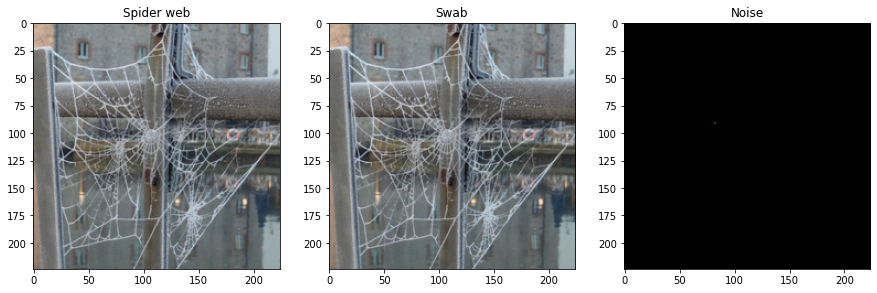

In [64]:
different_predictions = get_different_predictions(y_pred, y_pred_adv)
i = different_predictions[30]

print(f'Truth: {my_dataset.idx_to_class[y_true[i]]}')
plot_adversarial(my_dataset, adv_dataset, y_pred, y_pred_adv, i)